# Zustandsregelung - Teil 3: Linearisierung

LV Elektronische Steuerungs- und Regelungssysteme SS2021 (Master ETuIT, HSM, (c) Christoph Menz) 

***

Oftmals hat das zu regelnde System eine nichtlineare Struktur. Um dennoch mit den vorgestellten linearen Methoden einen Regler zu entwerfen, kann man das System um einen (oder mehrere) Arbeitspunkte linearisieren und den Entwurf am linearisierten Modell vornehmen. Dies wird in diesem Notebook exemplarisch dargestellt.    

***

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import control as ctrl
from scipy import signal

***

### Linearisierung um einen Arbeitspunkt

Ein System der Form

$
\dot{x} = f(x,u)
$

$
y = g(x,u)
$

kann mittels einer Taylorreihe erster (ggf. auch höherer) Ordnung um einen Arbeitspunkt $x_0,u_0$ approximiert werden:



$
f(x,u) \approx f(x_0,u_0) + \dfrac{\partial f}{\partial x}_{| x_0,u_0} (x - x_0) + 
\dfrac{\partial f}{\partial u}_{| x_0,u_0} (u - u_0)
$

$
g(x,u) \approx g(x_0,u_0) + \dfrac{\partial g}{\partial x}_{|x_0,u_0} (x - x_0) + 
\dfrac{\partial g}{\partial u}_{|x_0,u_0} (u - u_0)
$

mit

$
\Delta x = x - x_0
$

$
\Delta u = u - u_0
$

$
\Delta \dot{x} = f(x,u) - f(x_0,u_0)
$

$
\Delta y = g(x,u) - g(x_0,u_0)
$


sowie

$
A_0 = \dfrac{\partial f}{\partial x}_{|x_0,u_0}
$

$
B_0 = \dfrac{\partial f}{\partial u}_{|x_0,u_0}
$

$
C_0 = \dfrac{\partial g}{\partial x}_{|x_0,u_0}
$

$
D_0 = \dfrac{\partial g}{\partial u}_{|x_0,u_0}
$


ergibt sich das lineariserte System

$
\Delta \dot{x} = A_0 \Delta x + B_0 \Delta u 
$

$
\Delta y = C_0 \Delta x + D_0 \Delta u 
$

an dem dann der Reglerentwurf wie gehabt vorgenommen werden kann. 

Setzt man voraus, dass sich im Arbeitspunkt das System in einer Ruhelage befindet und zeitlich nicht verändert, gilt

$
f(x_0,u_0) = 0
$

***

### Beispiel

Gegeben sei ein System 

$
\dot{x}_1 = 1 - x_1 - x_1 x_2
$

$
\dot{x}_2 = - x_2 + \sin(u)
$

$
y = x_1
$

$
-0.5 \leq u \leq 0.5
$

das um einen Arbeitspunkt $x_0 = {(x_{1_0},x_{2_0)}}^T,u_0$ geregelt werden soll. Wir linearisieren das System um diesen Punkt:






$ 
A_0 = \begin{bmatrix}
\dfrac{\partial{f_1}}{\partial{x_1}}_{|x_0,u_0} &
\dfrac{\partial{f_1}}{\partial{x_2}}_{|x_0,u_0} \\
\dfrac{\partial{f_2}}{\partial{x_1}}_{|x_0,u_0} &
\dfrac{\partial{f_2}}{\partial{x_2}}_{|x_0,u_0} 
\end{bmatrix} 
= \begin{bmatrix}
-1-x_{2_0} &
-x_{1_0} \\
0 &
-1 
\end{bmatrix} 
$


$
B_0 = 
\begin{bmatrix}
\dfrac{\partial f_1}{\partial u}_{|x_0,u_0} \\
\dfrac{\partial f_2}{\partial u}_{|x_0,u_0} 
\end{bmatrix}
= \begin{bmatrix}
0 \\
\cos(u_0) 
\end{bmatrix}
$



$
C_0 = 
\begin{bmatrix}
1 &
0 
\end{bmatrix}
$

In der Ruhelage gilt

$
0 = 1 - x_1 - x_1 x_2
$

$
0 = - x_2 + \sin(u)
$

$
y = x_1
$

und damit

$
x_1 (1 + x_2) = 1
$

$
x_2 = \sin(u)
$


Wollen wir beispielsweise den Augang um einen Sollwert $0.8 \leq w \leq 1.2$ stabilisieren, bietet sich eine Linearisierung um $y = x_1 = 1.0$ an. Es ergibt sich damit der Arbeitspunkt $x_{10} = 1, x_{20} = 0, u_0 = 0$. 

Die Jacobi-Matrizen lauten somit:

$
A_0 = 
\begin{bmatrix}
-1 &
-1 \\
0 &
-1 
\end{bmatrix}
$

$
B_0 = 
\begin{bmatrix}
0 \\
1 
\end{bmatrix}
$

In [52]:
# linearisiertes System
A0 = [[-1.,-1.],[0,-1]]
b0 = [[0],[1]]
c0 = [[1,0]]
d0 = [0]

# ZR-System
#linsys = ctrl.ss(A0,b0,c0,d0)

In [13]:
# Steuerbarkeitsmatrix
#Cm = ctrl.ctrb(A0, b0)
# Rang 
#N = np.linalg.matrix_rank(Cm)

#print("Rang = " + str(N)) 

Rang = 2


In [53]:
# Eigenwerte 
p = [-1.5,-3]

# Reglermatrix
#K = ctrl.place(A0,b0,p)

#print("k = " + str(K))

In [54]:
kk = signal.place_poles(np.array(A0),np.array(b0),np.array(p))
K = kk.gain_matrix
print(K)

[[-1.   2.5]]


In [55]:
# Vorfilter
BK_A = np.linalg.inv(np.dot(b0,K)-A0)
S_inv = np.dot(c0,np.dot(BK_A,b0))
S = np.linalg.inv(S_inv) 

print("S = " + str(S))

S = [[-4.5]]


In [56]:
# Nichtlineares System 
def f(x,u):
    dx = np.zeros(2)
    dx[0] = 1 - x[0] - x[0]*x[1]
    dx[1] = -x[1] + np.sin(u)
    return dx

def g(x,u):
    y = x[0]
    return y

Simulation:

In [57]:
dt = 0.01 
t = np.arange(0,10+dt,dt) 

u = np.zeros(len(t)) # Eingangsgröße 
x = np.zeros([len(t)+1,2]) # Zustandsgrößen
y = np.zeros(len(t)) # Ausgangsgröße

# Linearisierungspunkt
x0 = np.array([1,0])
u0 = 0

# Anfangszustand
xa = np.array([0.5,0.5])
x[0] = xa

#Sollwert 
w = 0.8
dw = w - x0[0]

for k in range(len(t)):
    
    # Regler
    u[k] = - np.dot(K,x[k]-x0) + S*dw
    # Beschränkung
    if u[k] < -0.5:
        u[k] = -0.5
    if u[k] > 0.5:
        u[k] = 0.5
    
    # System simulieren (Euler)
    dx = f(x[k],u[k])
    x[k+1] = x[k] + dx*dt
    # Ausgangsgröße
    y[k] = g(x[k],u[k])

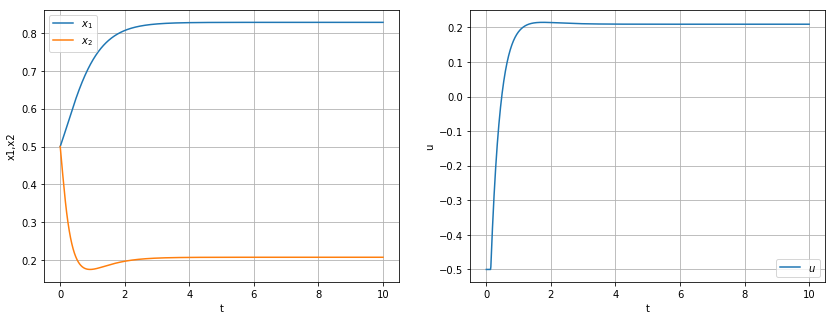

In [58]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(t, x[:len(t),0])
plt.plot(t, x[:len(t),1])
plt.grid()
plt.xlabel('t')
plt.ylabel('x1,x2')
plt.legend(['$x_1$','$x_2$'])

plt.subplot(1,2,2)
plt.plot(t, u)
plt.grid()
plt.xlabel('t')
plt.ylabel('u')
plt.legend(['$u$'])
plt.show()

Da das Vorfilter für Abweichungen vom Linearisierungspunkt keine stationäre Genauigkeit erreicht, bietet sich der Einsatz der Integralen Ausgangsrückführung an:

In [59]:
# erwitertes linearisiertes System
A1 = [[-1.,-1.,0],[0,-1,0],[-1,0,0]]
b1 = [[0],[1],[0]]

# Eigenwerte 
p1 = np.array([-1,-1.5,-2])-0

# Reglermatrix
#K1 = ctrl.place(A1,b1,p1)
k1 = signal.place_poles(np.array(A1),np.array(b1),np.array(p1))
K1 = k1.gain_matrix
print(K1)

[[-3.   2.5  3. ]]


In [60]:
dt = 0.01 
t = np.arange(0,10+dt,dt) 

u = np.zeros(len(t)) # Eingangsgröße 
x = np.zeros([len(t)+1,2]) # Zustandsgrößen
y = np.zeros(len(t)) # Ausgangsgröße

# Linearisierungspunkt
x0 = np.array([1,0])
u0 = 0

# Anfangszustand
xa = np.array([0.5,0.5])
x[0] = xa

# Sollwert 
w = 1.3

# Fehlerintegral
ei = 0.5*K1[0,0]/K1[0,2]

for k in range(len(t)):
    
    # Fehler integrieren
    if(k > 0):
        e = w - y[k-1] 
        # Anti-Windup
        if u[k-1] > -0.5:
            if u[k-1] < 0.5:
                ei += e*dt
        
    # Zustandsvektor erweitern und Offset korrigieren
    xerw = np.array([x[k,0]-x0[0],x[k,1]-x0[1],ei])
    # Stellgröße berechnen 
    u[k] = - np.dot(K1,xerw)
    # Beschränkung
    if u[k] < -0.5:
        u[k] = -0.5
    if u[k] > 0.5:
        u[k] = 0.5
        
    # System simulieren (Euler)
    dx = f(x[k],u[k])
    x[k+1] = x[k] + dx*dt
    # Ausgangsgröße
    y[k] = g(x[k],u[k])

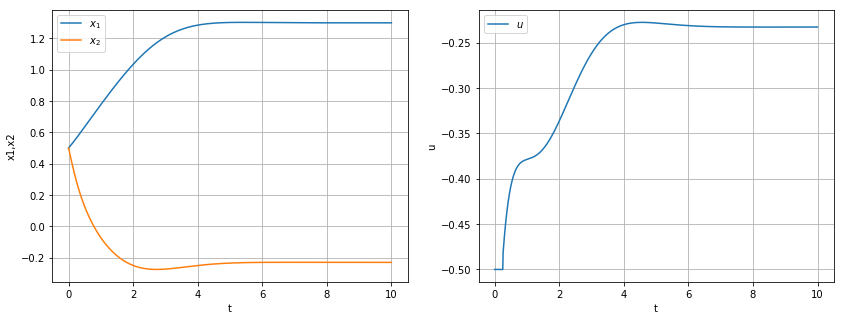

In [61]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(t, x[:len(t),0])
plt.plot(t, x[:len(t),1])
plt.grid()
plt.xlabel('t')
plt.ylabel('x1,x2')
plt.legend(['$x_1$','$x_2$'])

plt.subplot(1,2,2)
plt.plot(t, u)
plt.grid()
plt.xlabel('t')
plt.ylabel('u')
plt.legend(['$u$'])
plt.show()